#### JACOB AND THE F.L.O.W. MACHINE
Upon visiting a small village, you notice a mysterious-looking shop with a sign above the door that says
JACOB’S. Intrigued, you cautiously enter and ask the old
man standing behind the counter what he sells 

He replies that he offers a service for digitizing
paintings, with a difference. After a brief moment
rummaging around the back of the shop, he brings out a
silver box, embossed with the letters F.L.O.W. He tells
you that this stands for Finding Likenesses Of
Watercolors, which approximately describes what the
machine does. You decide to give the machine a try.

You come back the next day and hand the shopkeeper a
set of your favorite paintings, and he passes them
through the machine. The F.L.O.W. machine begins to
hum and whistle and after a while outputs a set of
numbers that appear randomly generated. The shopkeeper hands you the list and begins to walk to the
till to calculate how much you owe him for the
digitization process and the F.L.O.W. box. Distinctly
unimpressed, you ask the shopkeeper what you should
do with this long list of numbers, and how you can get
your favorite paintings back.

The shopkeeper rolls his eyes, as if the answer should
be obvious. He walks back to the machine and passes in
the long list of numbers, this time from the opposite
side. You hear the machine whir again and wait,
puzzled, until finally your original paintings drop out
from where they entered.

Relieved to finally have your paintings back, you decide
that it might be best to just store them in the attic
instead. However, before you have a chance to leave,
the shopkeeper ushers you across to a different corner
of the shop, where a giant bell hangs from the rafters.
He hits the bell curve with a huge stick, sending
vibrations around the store.

Instantly, the F.L.O.W. machine under your arm begins
to hiss and whirr in reverse, as if a new set of numbers
had just been passed in. After a few moments, more
beautiful watercolor paintings begin to fall out of the
F.L.O.W. machine, but they are not the same as the ones
you originally digitized. They resemble the style and
form of your original set of paintings, but each one is
completely unique!

You ask the shopkeeper how this incredible device
works. He explains that the magic lies in the fact that he
has developed a special process that ensures the
transformation is extremely fast and simple to calculate
while still being sophisticated enough to convert the vibrations produced by the bell into the complex
patterns and shapes present in the paintings.

Realizing the potential of this contraption, you hurriedly
pay for the device and exit the store, happy that you
now have a way to generate new paintings in your
favorite style, simply by visiting the shop, chiming the
bell, and waiting for your F.L.O.W. machine to work its
magic!



#### Normalizing Flows
In this chapter, we will cover a new family of generative
models—normalizing flow models. As we shall see,
normalizing flows share similarities with both
autoregressive models and variational autoencoders. 
- Like
autoregressive models, normalizing flows are able to
explicitly and tractably model the data-generating
distribution p(x). 
- Like VAEs, normalizing flows attempt to
map the data into a simpler distribution, such as a Gaussian
distribution. 
- The key difference is that normalizing flows
place a constraint on the form of the mapping function, so
that it is invertible and can therefore be used to generate
new data points.

To recap, in a variational autoencoder, we learn
an encoder mapping function between a complex
distribution and a much simpler distribution that we can
sample from. We then also learn a decoder mapping
function from the simpler distribution to the complex
distribution, so that we can generate a new data point by
sampling a point z from the simpler distribution and
applying the learned transformation. Probabilistically
speaking, the decoder models p(x|z) but the encoder is only
an approximation q(z|x) of the true p(z|x)—the encoder and
decoder are two completely distinct neural networks.

In a normalizing flow model, the decoding function is
designed to be the exact inverse of the encoding function
and quick to calculate, giving normalizing flows the
property of tractability. However, neural networks are not
by default invertible functions. 

This raises the question of
how we can create an invertible process that converts
between a complex distribution (such as the data
generation distribution of a set of watercolor paintings) and
a much simpler distribution (such as a bell-shaped
Gaussian distribution) while still making use of the
flexibility and power of deep learning.

##### Change of variables
We can now write down a single equation that describes
the process for changing variables between X and Z.

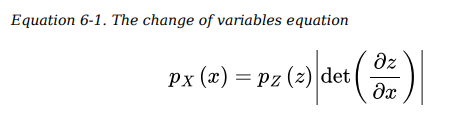

How does this help us build a generative model? The key is
understanding that if pZ (z) is a simple distribution from
which we can easily sample (e.g., a Gaussian), then in
theory, all we need to do is find an appropriate invertible
function f(x) that can map from the data X into Z and the
corresponding inverse function g(z) that can be used to
map a sampled z back to a point x in the original domain.
We can use the preceding equation involving the Jacobian
a b
c d
∣ ∣
determinant to find an exact, tractable formula for the data
distribution p(x).

#### RealNVP
RealNVP was first introduced by Dinh et al. in 2017.
1 In
this paper the authors show how to construct a neural
network that can transform a complex data distribution into
a simple Gaussian, while also possessing the desired
properties of being invertible and having a Jacobian that
can be easily calculated.


In [13]:
from sklearn import datasets
from tensorflow.keras import layers, metrics, losses, utils, callbacks, models,optimizers,regularizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

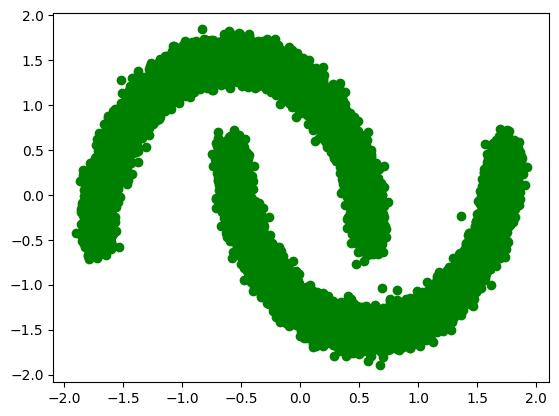

In [10]:
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()


##### Coupling layers
A coupling layer produces a scale and translation factor for
each element of its input. In other words, it produces two
tensors that are exactly the same size as the input, one for
the scale factor and one for the translation factor, 

In [7]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

In [17]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=input_dim)

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [18]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

In [19]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))


In [20]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
117/118 [============================>.] - ETA: 0s - loss: 2.5563
Saved to ./output/generated_img_000.png


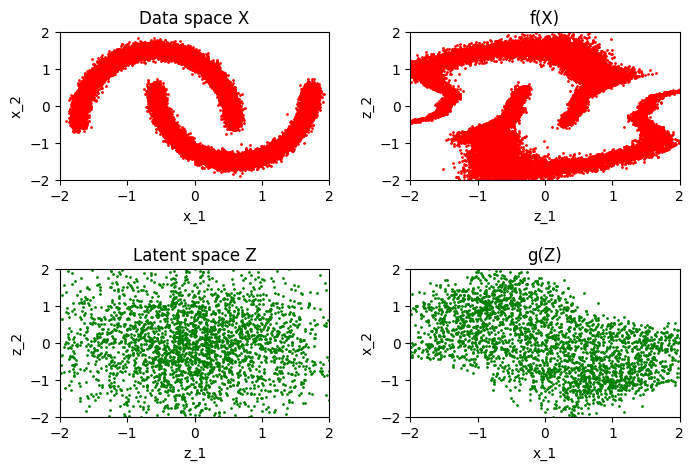

118/118 [==============================] - 20s 89ms/step - loss: 2.5556
Epoch 2/300
118/118 [==============================] - 3s 22ms/step - loss: 2.3400
Epoch 3/300
118/118 [==============================] - 2s 20ms/step - loss: 2.1859
Epoch 4/300
118/118 [==============================] - 2s 21ms/step - loss: 2.0663
Epoch 5/300
118/118 [==============================] - 2s 18ms/step - loss: 2.0084
Epoch 6/300
118/118 [==============================] - 2s 18ms/step - loss: 1.9666
Epoch 7/300
118/118 [==============================] - 2s 18ms/step - loss: 1.8787
Epoch 8/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7971
Epoch 9/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7714
Epoch 10/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7637
Epoch 11/300
118/118 [==============================] - ETA: 0s - loss: 1.7500
Saved to ./output/generated_img_010.png


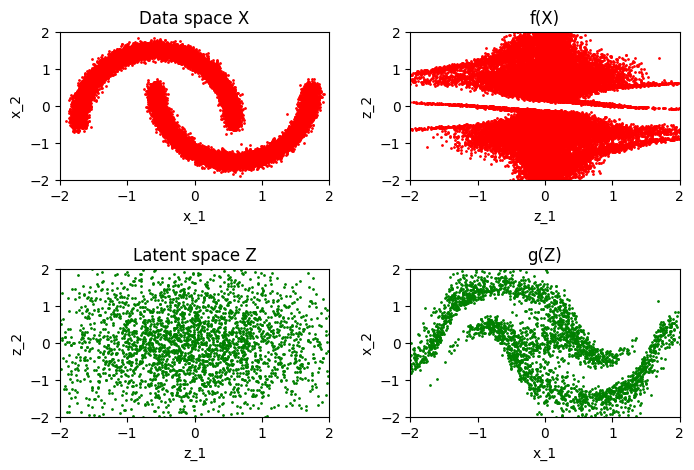

118/118 [==============================] - 8s 65ms/step - loss: 1.7500
Epoch 12/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7487
Epoch 13/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7474
Epoch 14/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7453
Epoch 15/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7409
Epoch 16/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7365
Epoch 17/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7410
Epoch 18/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7360
Epoch 19/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7366
Epoch 20/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7367
Epoch 21/300
115/118 [============================>.] - ETA: 0s - loss: 1.7322
Saved to ./output/generated_img_020.png


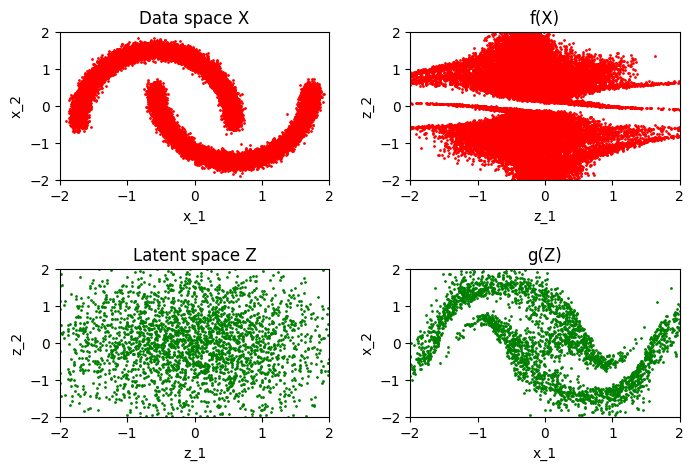

118/118 [==============================] - 8s 64ms/step - loss: 1.7311
Epoch 22/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7346
Epoch 23/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7304
Epoch 24/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7332
Epoch 25/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7274
Epoch 26/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7299
Epoch 27/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7298
Epoch 28/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7291
Epoch 29/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7264
Epoch 30/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7273
Epoch 31/300
118/118 [==============================] - ETA: 0s - loss: 1.7257
Saved to ./output/generated_img_030.png


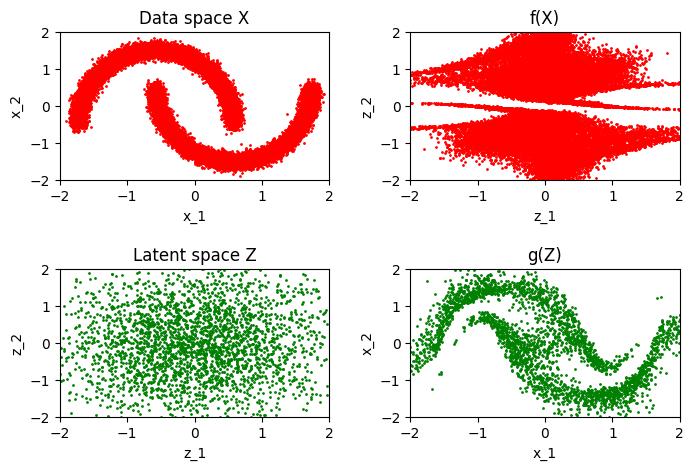

118/118 [==============================] - 8s 70ms/step - loss: 1.7257
Epoch 32/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7253
Epoch 33/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7273
Epoch 34/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7246
Epoch 35/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7260
Epoch 36/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7265
Epoch 37/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7232
Epoch 38/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7235
Epoch 39/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7198
Epoch 40/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7236
Epoch 41/300
118/118 [==============================] - ETA: 0s - loss: 1.7199
Saved to ./output/generated_img_040.png


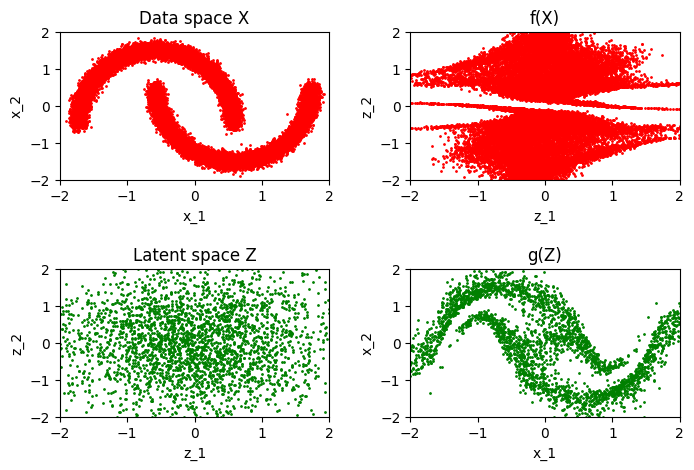

118/118 [==============================] - 8s 66ms/step - loss: 1.7199
Epoch 42/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7187
Epoch 43/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7246
Epoch 44/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7200
Epoch 45/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7202
Epoch 46/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7232
Epoch 47/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7173
Epoch 48/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7296
Epoch 49/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7254
Epoch 50/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7200
Epoch 51/300
116/118 [============================>.] - ETA: 0s - loss: 1.7237
Saved to ./output/generated_img_050.png


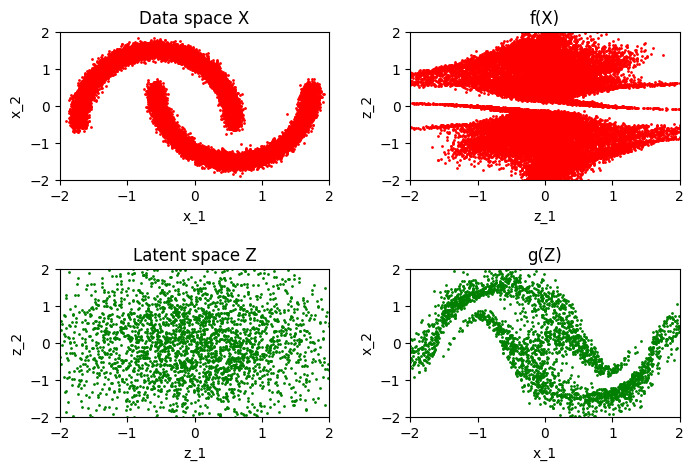

118/118 [==============================] - 8s 71ms/step - loss: 1.7234
Epoch 52/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7213
Epoch 53/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7163
Epoch 54/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7159
Epoch 55/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7183
Epoch 56/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7149
Epoch 57/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7165
Epoch 58/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7344
Epoch 59/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7169
Epoch 60/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7161
Epoch 61/300
117/118 [============================>.] - ETA: 0s - loss: 1.7160
Saved to ./output/generated_img_060.png


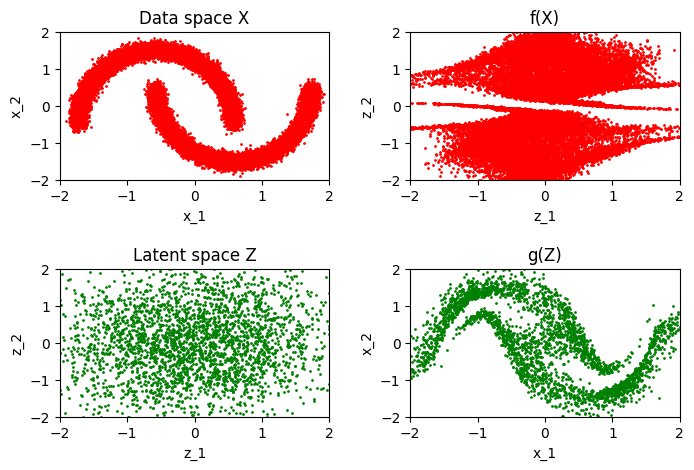

118/118 [==============================] - 8s 67ms/step - loss: 1.7186
Epoch 62/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7173
Epoch 63/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7245
Epoch 64/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7142
Epoch 65/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7141
Epoch 66/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7176
Epoch 67/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7166
Epoch 68/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7179
Epoch 69/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7169
Epoch 70/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7197
Epoch 71/300
118/118 [==============================] - ETA: 0s - loss: 1.7193
Saved to ./output/generated_img_070.png


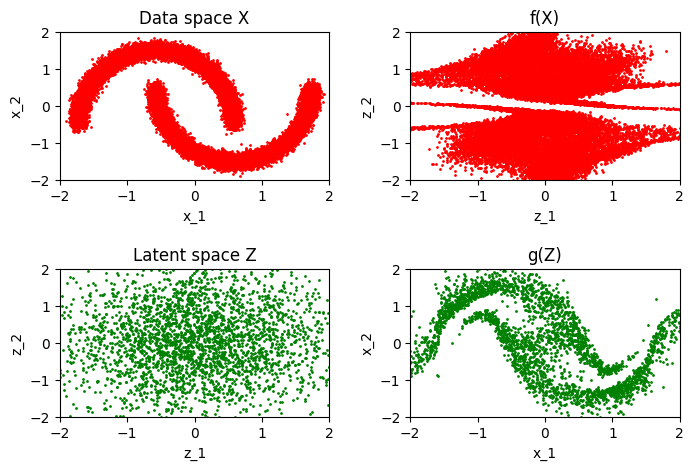

118/118 [==============================] - 9s 74ms/step - loss: 1.7193
Epoch 72/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7157
Epoch 73/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7172
Epoch 74/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7120
Epoch 75/300
118/118 [==============================] - 3s 21ms/step - loss: 1.7138
Epoch 76/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7142
Epoch 77/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7165
Epoch 78/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7117
Epoch 79/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7153
Epoch 80/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7123
Epoch 81/300
116/118 [============================>.] - ETA: 0s - loss: 1.7122
Saved to ./output/generated_img_080.png


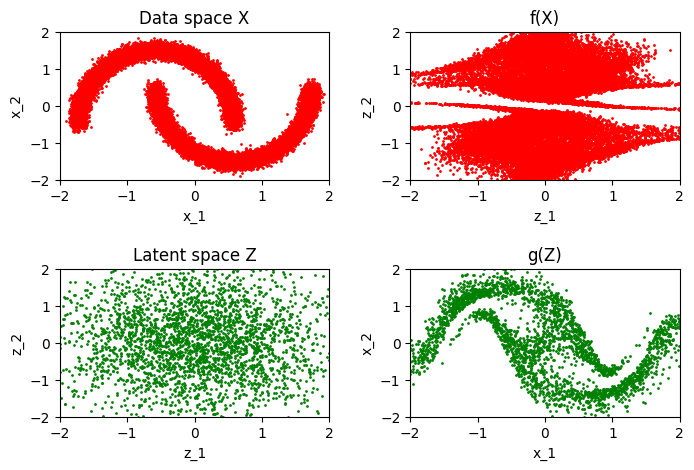

118/118 [==============================] - 8s 67ms/step - loss: 1.7137
Epoch 82/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7106
Epoch 83/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7134
Epoch 84/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7160
Epoch 85/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7081
Epoch 86/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7166
Epoch 87/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7131
Epoch 88/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7132
Epoch 89/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7151
Epoch 90/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7139
Epoch 91/300
117/118 [============================>.] - ETA: 0s - loss: 1.7096
Saved to ./output/generated_img_090.png


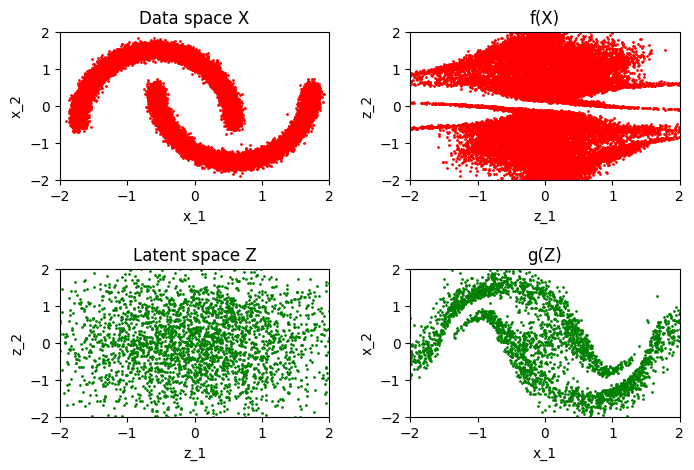

118/118 [==============================] - 8s 71ms/step - loss: 1.7100
Epoch 92/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7092
Epoch 93/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7116
Epoch 94/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7111
Epoch 95/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7090
Epoch 96/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7104
Epoch 97/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7128
Epoch 98/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7120
Epoch 99/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7074
Epoch 100/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7129
Epoch 101/300
118/118 [==============================] - ETA: 0s - loss: 1.7113
Saved to ./output/generated_img_100.png


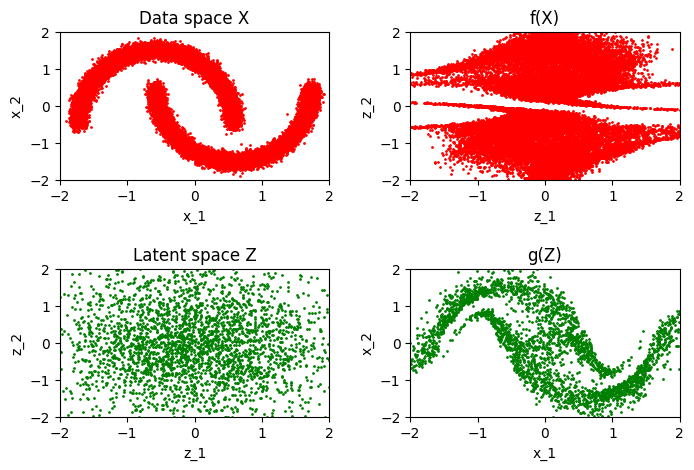

118/118 [==============================] - 8s 66ms/step - loss: 1.7113
Epoch 102/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7073
Epoch 103/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7145
Epoch 104/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7096
Epoch 105/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7081
Epoch 106/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7129
Epoch 107/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7368
Epoch 108/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7124
Epoch 109/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7099
Epoch 110/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7051
Epoch 111/300
117/118 [============================>.] - ETA: 0s - loss: 1.7092
Saved to ./output/generated_img_110.png


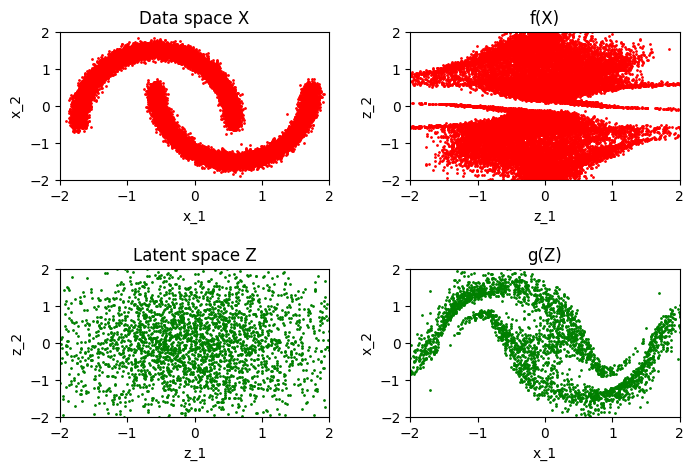

118/118 [==============================] - 8s 64ms/step - loss: 1.7089
Epoch 112/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7102
Epoch 113/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7077
Epoch 114/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7106
Epoch 115/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7101
Epoch 116/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7083
Epoch 117/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7227
Epoch 118/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7111
Epoch 119/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7131
Epoch 120/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7105
Epoch 121/300
116/118 [============================>.] - ETA: 0s - loss: 1.7089
Saved to ./output/generated_img_120.png


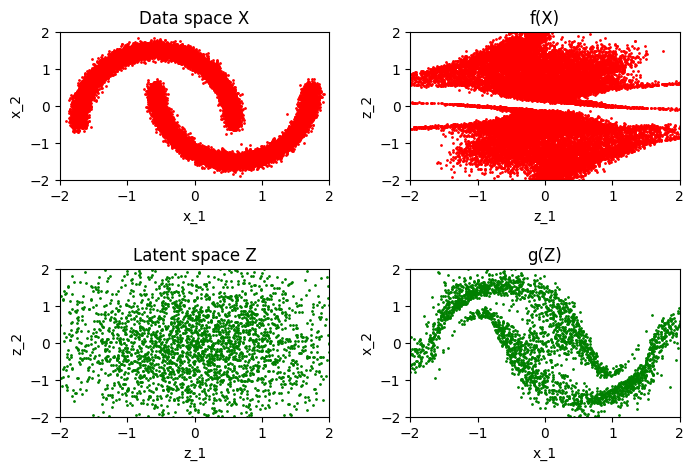

118/118 [==============================] - 8s 66ms/step - loss: 1.7080
Epoch 122/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7118
Epoch 123/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7091
Epoch 124/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7122
Epoch 125/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7084
Epoch 126/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7094
Epoch 127/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7181
Epoch 128/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7101
Epoch 129/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7116
Epoch 130/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7093
Epoch 131/300
116/118 [============================>.] - ETA: 0s - loss: 1.7068
Saved to ./output/generated_img_130.png


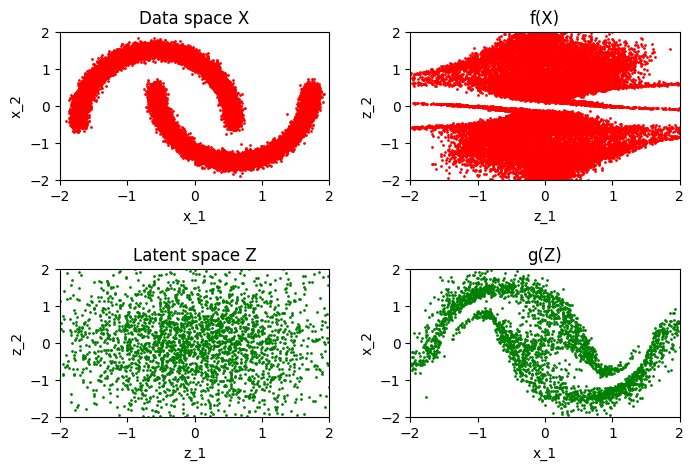

118/118 [==============================] - 8s 66ms/step - loss: 1.7066
Epoch 132/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7097
Epoch 133/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7114
Epoch 134/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7163
Epoch 135/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7061
Epoch 136/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7085
Epoch 137/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7050
Epoch 138/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7051
Epoch 139/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7163
Epoch 140/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7044
Epoch 141/300
118/118 [==============================] - ETA: 0s - loss: 1.7073
Saved to ./output/generated_img_140.png


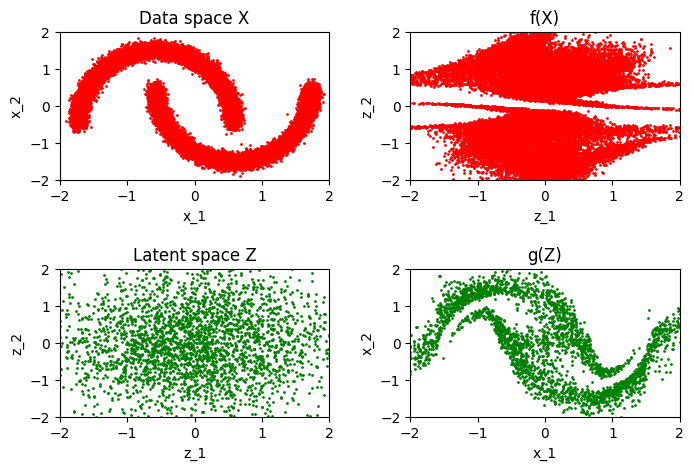

118/118 [==============================] - 8s 65ms/step - loss: 1.7073
Epoch 142/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7067
Epoch 143/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7062
Epoch 144/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7038
Epoch 145/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7080
Epoch 146/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7094
Epoch 147/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7072
Epoch 148/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7067
Epoch 149/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7035
Epoch 150/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7058
Epoch 151/300
118/118 [==============================] - ETA: 0s - loss: 1.7048
Saved to ./output/generated_img_150.png


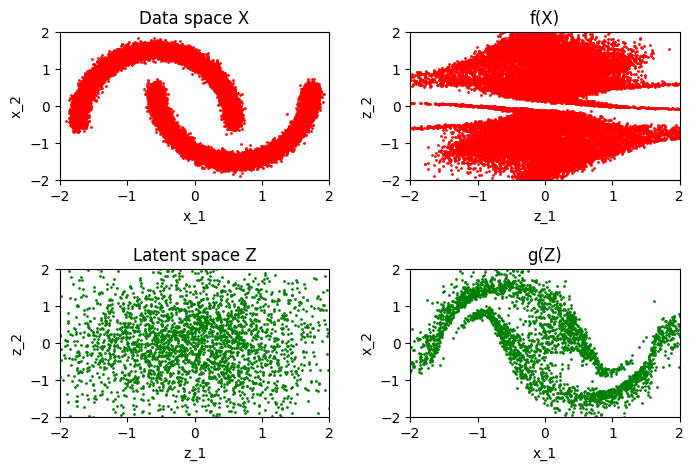

118/118 [==============================] - 8s 68ms/step - loss: 1.7048
Epoch 152/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7069
Epoch 153/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7058
Epoch 154/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7149
Epoch 155/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7095
Epoch 156/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7048
Epoch 157/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7084
Epoch 158/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7107
Epoch 159/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7084
Epoch 160/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7075
Epoch 161/300
116/118 [============================>.] - ETA: 0s - loss: 1.7055
Saved to ./output/generated_img_160.png


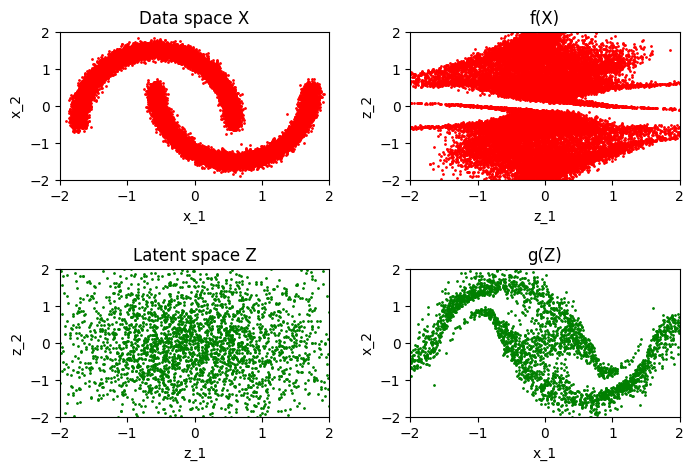

118/118 [==============================] - 8s 66ms/step - loss: 1.7047
Epoch 162/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7065
Epoch 163/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7094
Epoch 164/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7062
Epoch 165/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7045
Epoch 166/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7040
Epoch 167/300
118/118 [==============================] - 3s 24ms/step - loss: 1.7065
Epoch 168/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7097
Epoch 169/300
118/118 [==============================] - 4s 33ms/step - loss: 1.7081
Epoch 170/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7043
Epoch 171/300
118/118 [==============================] - ETA: 0s - loss: 1.7046
Saved to ./output/generated_img_170.png


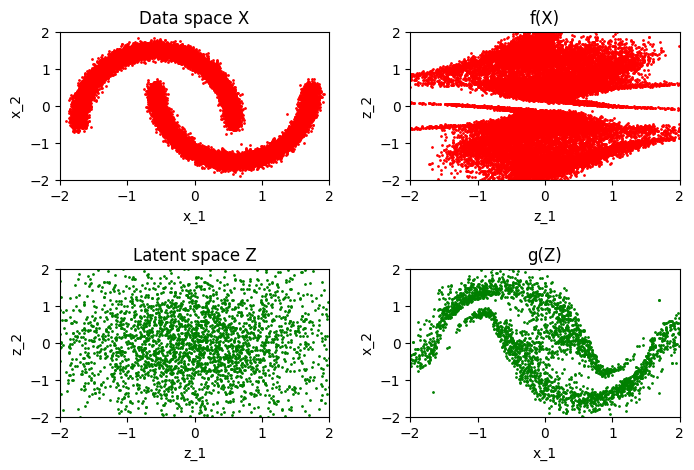

118/118 [==============================] - 10s 86ms/step - loss: 1.7046
Epoch 172/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7091
Epoch 173/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7030
Epoch 174/300
118/118 [==============================] - 3s 21ms/step - loss: 1.7069
Epoch 175/300
118/118 [==============================] - 3s 29ms/step - loss: 1.7038
Epoch 176/300
118/118 [==============================] - 3s 25ms/step - loss: 1.7096
Epoch 177/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7076
Epoch 178/300
118/118 [==============================] - 4s 30ms/step - loss: 1.7098
Epoch 179/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7032
Epoch 180/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7059
Epoch 181/300
117/118 [============================>.] - ETA: 0s - loss: 1.7073
Saved to ./output/generated_img_180.png


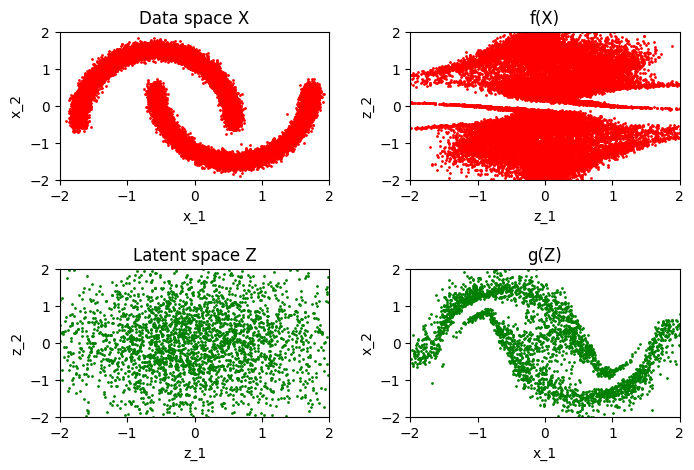

118/118 [==============================] - 8s 70ms/step - loss: 1.7072
Epoch 182/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7020
Epoch 183/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7080
Epoch 184/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7029
Epoch 185/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7083
Epoch 186/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7093
Epoch 187/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7051
Epoch 188/300
118/118 [==============================] - 3s 24ms/step - loss: 1.7068
Epoch 189/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7091
Epoch 190/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7092
Epoch 191/300
117/118 [============================>.] - ETA: 0s - loss: 1.7032
Saved to ./output/generated_img_190.png


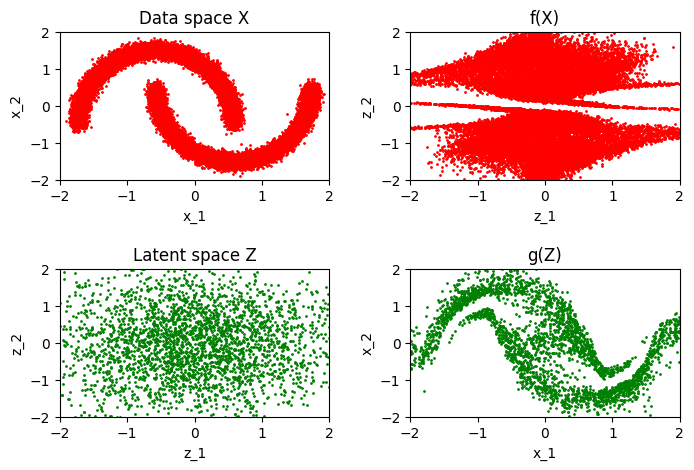

118/118 [==============================] - 10s 82ms/step - loss: 1.7035
Epoch 192/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7065
Epoch 193/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7087
Epoch 194/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7035
Epoch 195/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7024
Epoch 196/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7062
Epoch 197/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7060
Epoch 198/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7066
Epoch 199/300
118/118 [==============================] - 3s 28ms/step - loss: 1.7022
Epoch 200/300
118/118 [==============================] - 3s 24ms/step - loss: 1.7058
Epoch 201/300
117/118 [============================>.] - ETA: 0s - loss: 1.7061
Saved to ./output/generated_img_200.png


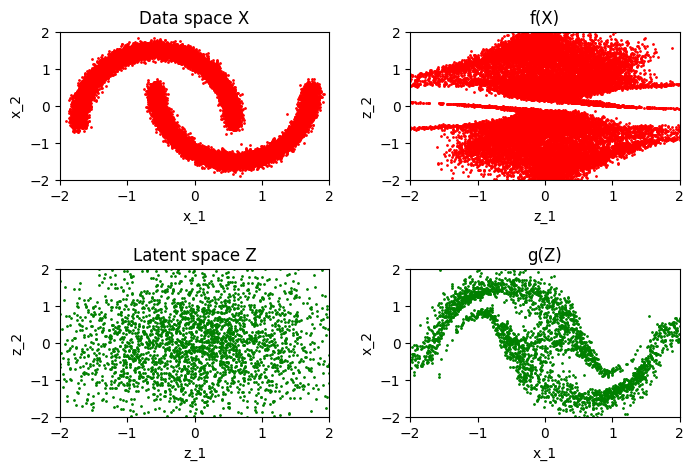

118/118 [==============================] - 9s 75ms/step - loss: 1.7062
Epoch 202/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7039
Epoch 203/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7045
Epoch 204/300
118/118 [==============================] - 3s 25ms/step - loss: 1.7053
Epoch 205/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7029
Epoch 206/300
118/118 [==============================] - 3s 24ms/step - loss: 1.7043
Epoch 207/300
118/118 [==============================] - 3s 27ms/step - loss: 1.7033
Epoch 208/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7034
Epoch 209/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7148
Epoch 210/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7075
Epoch 211/300
117/118 [============================>.] - ETA: 0s - loss: 1.7019
Saved to ./output/generated_img_210.png


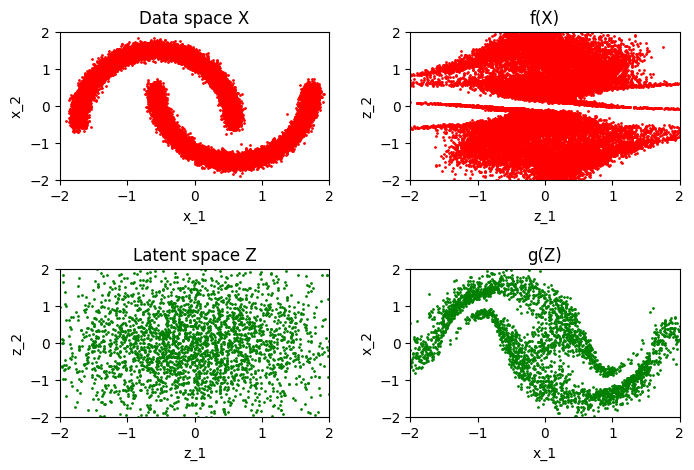

118/118 [==============================] - 8s 70ms/step - loss: 1.7010
Epoch 212/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7047
Epoch 213/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7022
Epoch 214/300
118/118 [==============================] - 3s 25ms/step - loss: 1.7063
Epoch 215/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7010
Epoch 216/300
118/118 [==============================] - 3s 21ms/step - loss: 1.7033
Epoch 217/300
118/118 [==============================] - 3s 21ms/step - loss: 1.7017
Epoch 218/300
118/118 [==============================] - 3s 27ms/step - loss: 1.7050
Epoch 219/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7057
Epoch 220/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7010
Epoch 221/300
117/118 [============================>.] - ETA: 0s - loss: 1.7036
Saved to ./output/generated_img_220.png


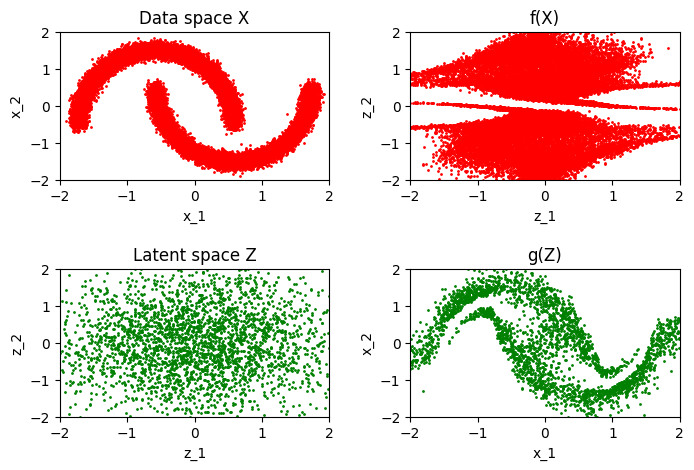

118/118 [==============================] - 11s 90ms/step - loss: 1.7032
Epoch 222/300
118/118 [==============================] - 4s 34ms/step - loss: 1.7045
Epoch 223/300
118/118 [==============================] - 3s 25ms/step - loss: 1.7034
Epoch 224/300
118/118 [==============================] - 3s 26ms/step - loss: 1.7102
Epoch 225/300
118/118 [==============================] - 4s 32ms/step - loss: 1.7060
Epoch 226/300
118/118 [==============================] - 3s 29ms/step - loss: 1.7047
Epoch 227/300
118/118 [==============================] - 3s 27ms/step - loss: 1.7045
Epoch 228/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7079
Epoch 229/300
118/118 [==============================] - 3s 25ms/step - loss: 1.6994
Epoch 230/300
118/118 [==============================] - 3s 25ms/step - loss: 1.7002
Epoch 231/300
116/118 [============================>.] - ETA: 0s - loss: 1.7057
Saved to ./output/generated_img_230.png


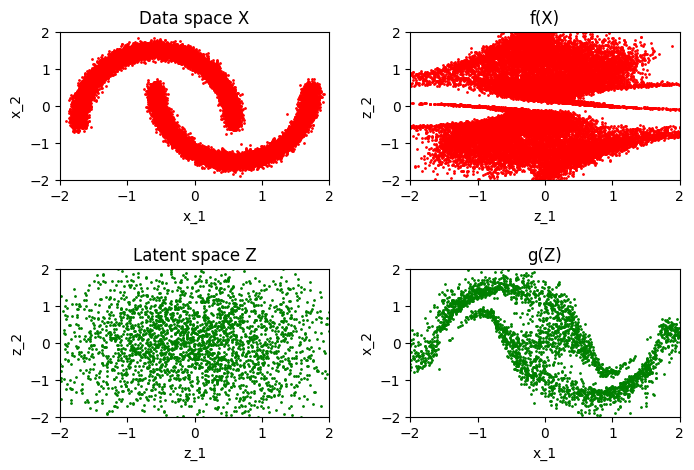

118/118 [==============================] - 9s 81ms/step - loss: 1.7070
Epoch 232/300
118/118 [==============================] - 3s 24ms/step - loss: 1.7064
Epoch 233/300
118/118 [==============================] - 3s 26ms/step - loss: 1.7006
Epoch 234/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7012
Epoch 235/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7035
Epoch 236/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7017
Epoch 237/300
118/118 [==============================] - 3s 26ms/step - loss: 1.7036
Epoch 238/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7018
Epoch 239/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7097
Epoch 240/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7028
Epoch 241/300
118/118 [==============================] - ETA: 0s - loss: 1.7010
Saved to ./output/generated_img_240.png


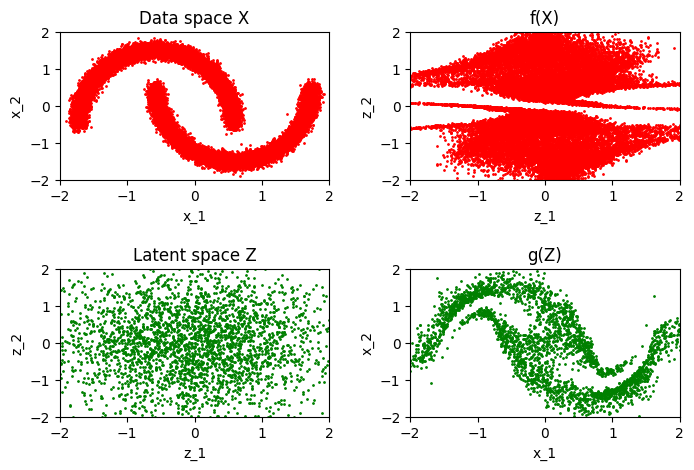

118/118 [==============================] - 9s 73ms/step - loss: 1.7010
Epoch 242/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7015
Epoch 243/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7022
Epoch 244/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7016
Epoch 245/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7026
Epoch 246/300
118/118 [==============================] - 3s 23ms/step - loss: 1.7066
Epoch 247/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7026
Epoch 248/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7082
Epoch 249/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7029
Epoch 250/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7016
Epoch 251/300
118/118 [==============================] - ETA: 0s - loss: 1.7024
Saved to ./output/generated_img_250.png


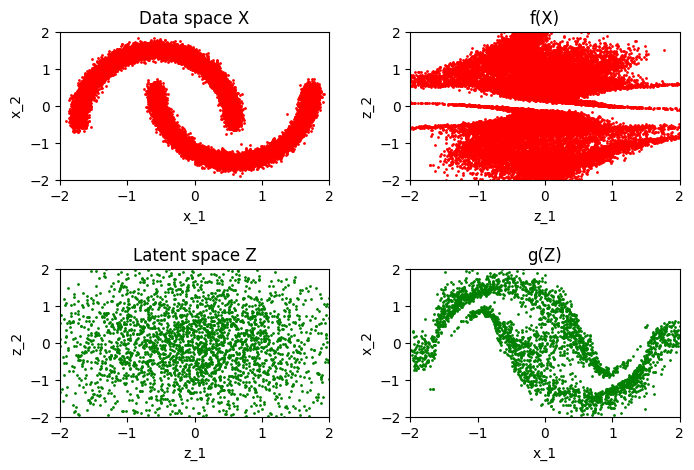

118/118 [==============================] - 8s 68ms/step - loss: 1.7024
Epoch 252/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7110
Epoch 253/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7038
Epoch 254/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7038
Epoch 255/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7085
Epoch 256/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7007
Epoch 257/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7047
Epoch 258/300
118/118 [==============================] - 2s 20ms/step - loss: 1.6991
Epoch 259/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7026
Epoch 260/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7029
Epoch 261/300
116/118 [============================>.] - ETA: 0s - loss: 1.6999
Saved to ./output/generated_img_260.png


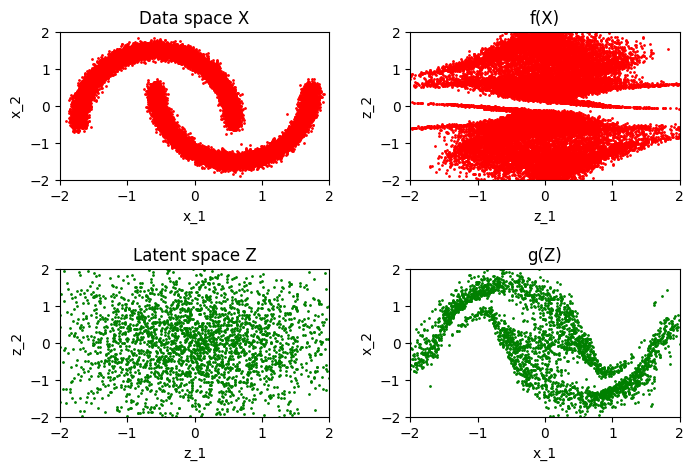

118/118 [==============================] - 8s 68ms/step - loss: 1.7012
Epoch 262/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7000
Epoch 263/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7036
Epoch 264/300
118/118 [==============================] - 3s 25ms/step - loss: 1.7032
Epoch 265/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7118
Epoch 266/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7017
Epoch 267/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7032
Epoch 268/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7038
Epoch 269/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7021
Epoch 270/300
118/118 [==============================] - 2s 17ms/step - loss: 1.6995
Epoch 271/300
118/118 [==============================] - ETA: 0s - loss: 1.7032
Saved to ./output/generated_img_270.png


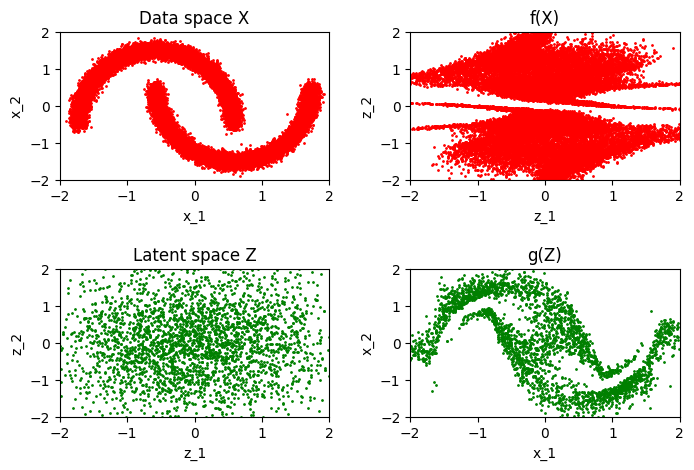

118/118 [==============================] - 9s 75ms/step - loss: 1.7032
Epoch 272/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7005
Epoch 273/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7028
Epoch 274/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7010
Epoch 275/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7023
Epoch 276/300
118/118 [==============================] - 2s 17ms/step - loss: 1.6981
Epoch 277/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7037
Epoch 278/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7054
Epoch 279/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7044
Epoch 280/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7037
Epoch 281/300
116/118 [============================>.] - ETA: 0s - loss: 1.7056
Saved to ./output/generated_img_280.png


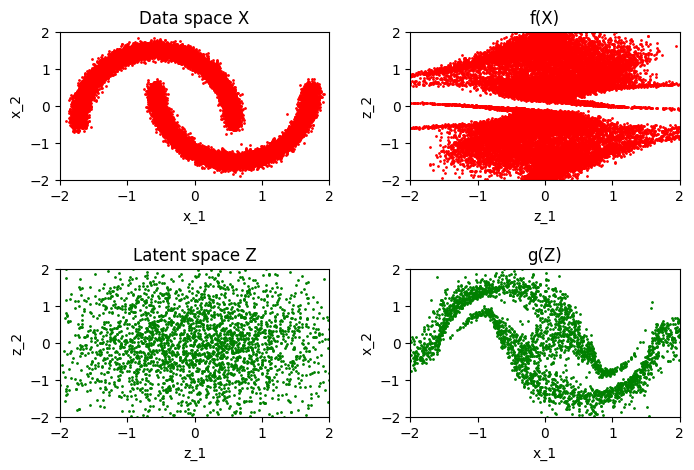

118/118 [==============================] - 9s 75ms/step - loss: 1.7066
Epoch 282/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7033
Epoch 283/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7098
Epoch 284/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7029
Epoch 285/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7032
Epoch 286/300
118/118 [==============================] - 3s 22ms/step - loss: 1.7030
Epoch 287/300
118/118 [==============================] - 2s 21ms/step - loss: 1.7025
Epoch 288/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7015
Epoch 289/300
118/118 [==============================] - 2s 19ms/step - loss: 1.6963
Epoch 290/300
118/118 [==============================] - 2s 20ms/step - loss: 1.7008
Epoch 291/300
118/118 [==============================] - ETA: 0s - loss: 1.7107
Saved to ./output/generated_img_290.png


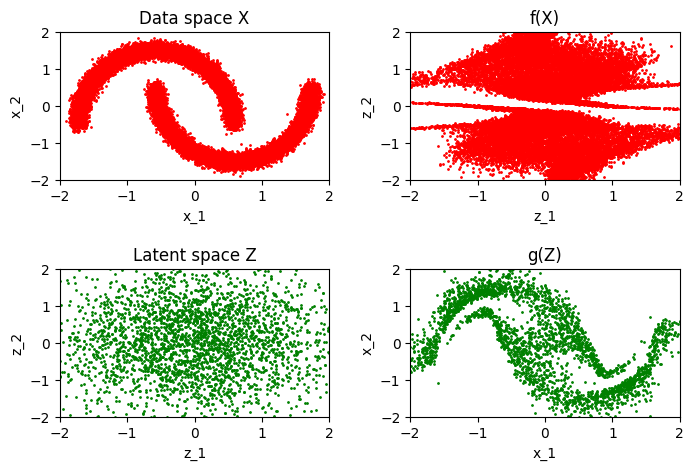

118/118 [==============================] - 9s 74ms/step - loss: 1.7107
Epoch 292/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7041
Epoch 293/300
118/118 [==============================] - 2s 18ms/step - loss: 1.6986
Epoch 294/300
118/118 [==============================] - 2s 19ms/step - loss: 1.7029
Epoch 295/300
118/118 [==============================] - 2s 17ms/step - loss: 1.7005
Epoch 296/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7028
Epoch 297/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7018
Epoch 298/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7020
Epoch 299/300
118/118 [==============================] - 2s 18ms/step - loss: 1.7013
Epoch 300/300
118/118 [==============================] - 2s 18ms/step - loss: 1.6988


In [21]:
model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

In [22]:
x, z, samples = img_generator_callback.generate()


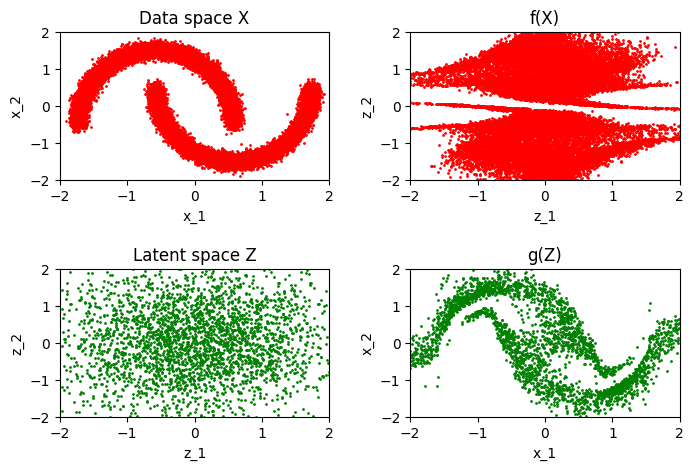

In [23]:
img_generator_callback.display(x, z, samples)

####